# U-Net图像分割

code来源：
https://www.kaggle.com/keegil/keras-u-net-starter-lb-0-277?scriptVersionId=2164855/notebook

数据来源code：
https://github.com/kamalkraj/DATA-SCIENCE-BOWL-2018/blob/master/Data_Science_Bowl_2018.ipynb

In [ ]:
# Data download and unzipping
!wget https://raw.githubusercontent.com/AakashSudhakar/2018-data-science-bowl/master/compressed_files/stage1_test.zip -c
!wget https://raw.githubusercontent.com/AakashSudhakar/2018-data-science-bowl/master/compressed_files/stage1_train.zip -c

!mkdir stage1_train stage1_test
!unzip stage1_train.zip -d stage1_train/
!unzip stage1_test.zip -d stage1_test/

In [1]:
import os
import sys
import random
import warnings

# 需要指定一下数据目录
sys.path.append('/mnt/unet/')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt


import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
set_session(tf.Session(config=config))

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = './stage1_train/'
TEST_PATH = './stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

# Get train and test IDs
train_ids = next(os.walk(TRAIN_PATH))[1]  # 670
test_ids = next(os.walk(TEST_PATH))[1]    # 65

Using TensorFlow backend.


## Get the data
Let's first import all the images and associated masks. I downsample both the training and test images to keep things light and manageable, but we need to keep a record of the original sizes of the test images to upsample our predicted masks and create correct run-length encodings later on. There are definitely better ways to handle this, but it works fine for now!


In [8]:
def data_generator(train_ids,test_ids):
    # Get and resize train images and masks
    X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    print('Getting and resizing train images and masks ... ')
    sys.stdout.flush()
    for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
        path = TRAIN_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True) # resize成128*128
        X_train[n] = img
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
        for mask_file in next(os.walk(path + '/masks/'))[2]:
            mask_ = imread(path + '/masks/' + mask_file)
            mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                          preserve_range=True), axis=-1)
            mask = np.maximum(mask, mask_)
        Y_train[n] = mask

    # Get and resize test images
    X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
    sizes_test = []
    print('Getting and resizing test images ... ')
    sys.stdout.flush()
    for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
        path = TEST_PATH + id_
        img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        sizes_test.append([img.shape[0], img.shape[1]])
        img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_test[n] = img

    print('Data Generate Done!')
    return X_train,Y_train,X_test,sizes_test

X_train,Y_train,X_test,sizes_test = data_generator(train_ids,test_ids)
# X_train (670, 128, 128, 3)
# Y_train (670, 128, 128, 1)
# X_test  (65, 128, 128, 3)
# sizes_test (65,2)

Getting and resizing train images and masks ... 


100%|██████████| 670/670 [01:16<00:00,  8.74it/s]

Getting and resizing test images ... 



100%|██████████| 65/65 [00:00<00:00, 100.11it/s]

Data Generate Done!


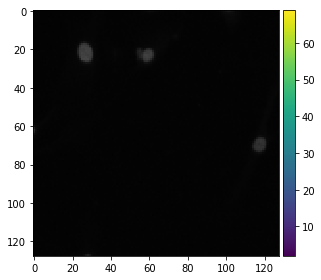

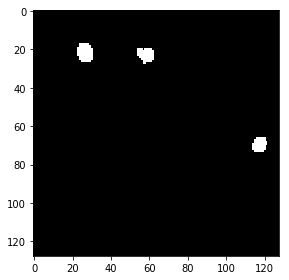

In [5]:
# Check if training data looks all right
# 查看数据是否正确
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

## Create our Keras metric
Now we try to define the mean average precision at different intersection over union (IoU) thresholds metric in Keras. TensorFlow has a mean IoU metric, but it doesn't have any native support for the mean over multiple thresholds, so I tried to implement this. I'm by no means certain that this implementation is correct, though! Any assistance in verifying this would be most welcome!

Update: This implementation is most definitely not correct due to the very large discrepancy between the results reported here and the LB results. It also seems to just increase over time no matter what when you train ...

In [5]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

## Build and train our neural network

Next we build our U-Net model, loosely based on U-Net: Convolutional Networks for Biomedical Image Segmentation and very similar to this repo from the Kaggle Ultrasound Nerve Segmentation competition.

![模型结构图](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)



In [6]:
def UNetModel(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255) (inputs)

    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
    c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
    c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
    c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
    c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
    c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
    c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
    c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
    c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

    u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
    c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
    return model

model = UNetModel(IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)

## Fit model

I'll just train for 10 epochs, which takes around 10 minutes in the Kaggle kernel with the current parameters.

Update: Added early stopping and checkpointing and increased to 30 epochs.

ou should easily be able to stabilize and improve the results just by changing a few parameters, tweaking the architecture a little bit and training longer with early stopping.

In [8]:
def model_fit(X_train,Y_train,model_name,epochs,batch_size,validation_split):
    earlystopper = EarlyStopping(patience=5, verbose=1)
    checkpointer = ModelCheckpoint(model_name, verbose=1, save_best_only=True)
    results = model.fit(X_train, Y_train, validation_split=validation_split, 
                        batch_size=batch_size, epochs=epochs, 
                        callbacks=[earlystopper, checkpointer])

model_name = 'model-dsbowl2018-1.h5'
epochs = 30
batch_size = 8
validation_split = 0.1
model_fit(X_train,Y_train,model_name,epochs,batch_size,validation_split)

Train on 603 samples, validate on 67 samples
Epoch 1/30
603/603 [==============================] - 6s 9ms/step - loss: 0.4996 - mean_iou: 0.4169 - val_loss: 0.3908 - val_mean_iou: 0.4232
Epoch 2/30
603/603 [==============================] - 3s 5ms/step - loss: 0.3260 - mean_iou: 0.4247 - val_loss: 0.2417 - val_mean_iou: 0.4361
Epoch 3/30
603/603 [==============================] - 3s 5ms/step - loss: 0.1856 - mean_iou: 0.4765 - val_loss: 0.1585 - val_mean_iou: 0.5148
Epoch 4/30
603/603 [==============================] - 3s 5ms/step - loss: 0.1384 - mean_iou: 0.5454 - val_loss: 0.1513 - val_mean_iou: 0.5742
Epoch 5/30
603/603 [==============================] - 3s 5ms/step - loss: 0.1200 - mean_iou: 0.5971 - val_loss: 0.1236 - val_mean_iou: 0.6175
Epoch 6/30
603/603 [==============================] - 3s 5ms/step - loss: 0.1130 - mean_iou: 0.6339 - val_loss: 0.1280 - val_mean_iou: 0.6477
Epoch 7/30
603/603 [==============================] - 3s 5ms/step - loss: 0.1072 - mean_iou: 0.6594 - v

Epoch 29/30
603/603 [==============================] - 3s 5ms/step - loss: 0.0754 - mean_iou: 0.8009 - val_loss: 0.0860 - val_mean_iou: 0.8018
Epoch 30/30
603/603 [==============================] - 3s 5ms/step - loss: 0.0728 - mean_iou: 0.8028 - val_loss: 0.0857 - val_mean_iou: 0.8037


In [20]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=30, 
                    callbacks=[earlystopper, checkpointer])

Train on 603 samples, validate on 67 samples
Epoch 1/30
603/603 [==============================] - 5s 8ms/step - loss: 0.0710 - mean_iou: 0.8533 - val_loss: 0.0836 - val_mean_iou: 0.8633
Epoch 2/30
603/603 [==============================] - 3s 5ms/step - loss: 0.0710 - mean_iou: 0.8615 - val_loss: 0.0874 - val_mean_iou: 0.8617
Epoch 3/30
603/603 [==============================] - 3s 5ms/step - loss: 0.0721 - mean_iou: 0.8608 - val_loss: 0.0911 - val_mean_iou: 0.8612
Epoch 4/30
603/603 [==============================] - 3s 5ms/step - loss: 0.0713 - mean_iou: 0.8620 - val_loss: 0.0822 - val_mean_iou: 0.8617
Epoch 5/30
603/603 [==============================] - 3s 5ms/step - loss: 0.0694 - mean_iou: 0.8619 - val_loss: 0.0894 - val_mean_iou: 0.8618
Epoch 6/30
603/603 [==============================] - 3s 5ms/step - loss: 0.0703 - mean_iou: 0.8622 - val_loss: 0.0828 - val_mean_iou: 0.8621
Epoch 7/30
603/603 [==============================] - 3s 5ms/step - loss: 0.0700 - mean_iou: 0.8622 - v

## Make predictions 预测
Let's make predictions both on the test set, the val set and the train set (as a sanity check). Remember to load the best saved model if you've used early stopping and checkpointing.

In [ ]:
# X_train (670, 128, 128, 3)
# Y_train (670, 128, 128, 1)
# X_test  (65, 128, 128, 3)

In [9]:
# Predict on train, val and test
model = load_model('model-dsbowl2018-1.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1) # (603, 128, 128, 1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)   # (67, 128, 128, 1)
preds_test = model.predict(X_test, verbose=1)  # (65, 128, 128, 1)

# Threshold predictions
# 二值化
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

# Create list of upsampled test masks
# 上采样，回到原来的尺寸
preds_test_upsampled = []  # (65,)
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), # 回到原来的尺寸
                                       mode='constant', preserve_range=True))

65/65 [==============================] - 0s 737us/step


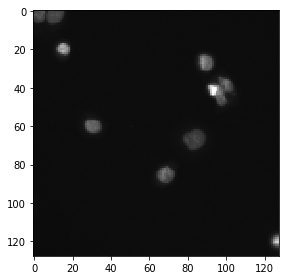

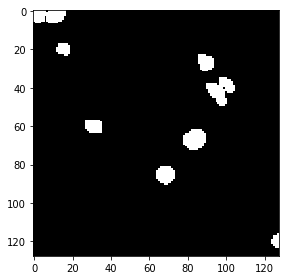

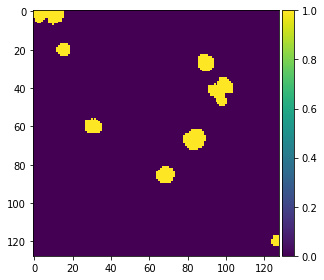

In [10]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))# 128*128*1
plt.show()
imshow(np.squeeze(preds_train_t[ix])) # 128*128*1
plt.show()

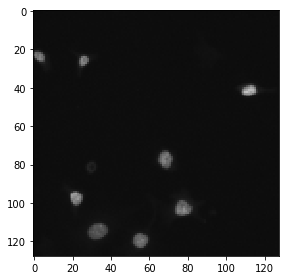

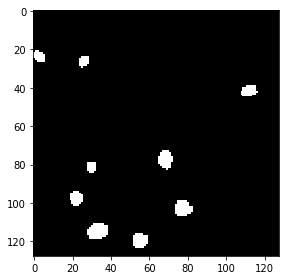

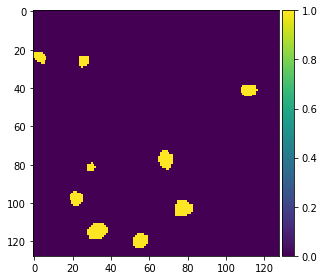

In [18]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()

## Encode and submit our results

    Run-Length Encoding（RLE）行程长度的原理是将一扫描行中的颜色值相同的相邻像素用一个计数值和那些像素的颜色值来代替。例如:aaabccccccddeee，则可用3a1b6c2d3e来代替。对于拥有大面积，相同颜色区域的图像，用RLE压缩方法非常有效。由RLE原理派生出许多具体行程压缩方法

In [25]:
# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    dots = np.where(x.T.flatten() == 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

def prob_to_rles(x, cutoff=0.5):
    lab_img = label(x > cutoff)
    for i in range(1, lab_img.max() + 1):
        yield rle_encoding(lab_img == i)

In [26]:
new_test_ids = []
rles = []
for n, id_ in enumerate(test_ids):
    rle = list(prob_to_rles(preds_test_upsampled[n]))
    rles.extend(rle)
    new_test_ids.extend([id_] * len(rle))

In [27]:
# Create submission DataFrame
sub = pd.DataFrame()
sub['ImageId'] = new_test_ids
sub['EncodedPixels'] = pd.Series(rles).apply(lambda x: ' '.join(str(y) for y in x))

In [ ]:
sub.to_csv('sub-dsbowl2018-1.csv', index=False)